This code is used to analyse the hypothesis 1 by computing average prices for male and female products on interesting intersections between brands and categories 

In [16]:
import time
import requests
import pandas as pd
import random
import json
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [17]:
#Here we create a dictionary to map category IDs to genders

gender_dict = {
    # HOMME — vêtements
    "32": "homme",
    "1206": "homme",
    "34": "homme",
    "85": "homme",
    "84": "homme",
    "92": "homme",
    "257": "homme",
    "76": "homme",
    "79": "homme",
    "80": "homme",
    "2910": "homme",
    "30": "homme",

    # HOMME — chaussures
    "1233": "homme",
    "2657": "homme",
    "1238": "homme",
    "2659": "homme",
    "1242": "homme",
    "2656": "homme",
    "2970": "homme",
    "2969": "homme",
    "2968": "homme",
    "1452": "homme",

    # FEMME — vêtements
    "13": "femme",
    "10": "femme",
    "12": "femme",
    "9": "femme",
    "1035": "femme",
    "29": "femme",
    "73": "femme",
    "1037": "femme",
    "8": "femme",
    "11": "femme",
    "183": "femme",
    "15": "femme",
    "28": "femme",
    "1176": "femme",
    "1782": "femme",

    # FEMME — chaussures
    "2954": "femme",
    "2623": "femme",
    "2955": "femme",
    "1049": "femme",
    "2953": "femme",
    "543": "femme",
    "2950": "femme",
    "215": "femme",
    "2632": "femme",
    "2952": "femme",
    "2951": "femme",
    "2949": "femme",
    "2630": "femme",
}


In [18]:
#Here we create a dictionary to map category IDs to super categories that can be considered similar for men and women 

category_dict = {
    # HOMME — vêtements
    "32": "suits and blazers",
    "1206": "outerwear",
    "34": "trousers",
    "85": "socks and underwear",
    "84": "swimwear",
    "92": "costumes and special outfits",
    "257": "jeans",
    "76": "tops and t-shirts",
    "79": "jumpers and sweaters",
    "80": "shorts",
    "2910": "sleepwear",
    "30": "activewear",

    # HOMME — chaussures
    "1233": "boots",
    "2657": "espadrilles",
    "1238": "formal shoes",
    "2659": "slippers",
    "1242": "trainers",
    "2656": "boat shoes, loafers and moccasins",
    "2970": "clogs and mules",
    "2969": "flip-flops and slides",
    "2968": "sandals",
    "1452": "sports shoes",

    # FEMME — vêtements
    "13": "jumpers and sweaters",
    "10": "dresses",
    "12": "tops and t-shirts",
    "9": "trousers and leggings",
    "1035": "jumpsuits and playsuits",
    "29": "lingerie and nightwear",
    "73": "activewear",
    "1037": "outerwear",
    "8": "suits and blazers",
    "11": "skirts",
    "183": "jeans",
    "15": "shorts and cropped trousers",
    "28": "swimwear",
    "1176": "maternity clothes",
    "1782": "costumes and special outfits",

    # FEMME — chaussures
    "2954": "boat shoes, loafers and moccasins",
    "2623": "clogs and mules",
    "2955": "ballerinas",
    "1049": "boots",
    "2953": "espadrilles",
    "543": "heels",
    "2950": "mary janes and t-bar shoes",
    "215": "slippers",
    "2632": "trainers",
    "2952": "flip-flops and slides",
    "2951": "lace-up shoes",
    "2949": "sandals",
    "2630": "sports shoes",
}


In [19]:
#Here we create a dictionary to map category titles to super categories that can be considered similar for men and women
super_category_dict = {
    # Pants / trousers / leggings
    "trousers": "trousers",
    "trousers and leggings": "trousers",
    "jeans": "jeans",
    "shorts": "shorts",
    "shorts and cropped trousers": "shorts",

    # Tops / T-shirts / jumpers
    "tops and t-shirts": "t-shirts",
    "jumpers and sweaters": "jumpers",
    "sweatshirts": "jumpers",
    
    # Dresses / skirts
    "dresses": "dresses",
    "skirts": "skirts",
    "jumpsuits and playsuits": "jumpsuits",

    # Outerwear
    "outerwear": "outerwear",
    
    # Suits / blazers
    "suits and blazers": "suits and blazers",
    
    # Swimwear / lingerie / activewear
    "swimwear": "swimwear",
    "lingerie and nightwear": "lingerie",
    "activewear": "activewear",
    "sleepwear": "sleepwear",
    "maternity clothes": "maternity clothes",
    "costumes and special outfits": "special outfits",
    
    # Shoes (all types merged)
    "boots": "shoes",
    "espadrilles": "shoes",
    "formal shoes": "shoes",
    "slippers": "shoes",
    "trainers": "shoes",
    "boat shoes, loafers and moccasins": "shoes",
    "clogs and mules": "shoes",
    "flip-flops and slides": "shoes",
    "sandals": "shoes",
    "sports shoes": "shoes",
    "ballerinas": "shoes",
    "heels": "shoes",
    "mary janes and t-bar shoes": "shoes",
    "lace-up shoes": "shoes"
}


In [21]:
#This script converts the raw JSONL data obtained from Vinted scraping into a cleaned JSON file with selected fields.

#The input_path path may need to be changed to your local paths obtained with the scrapping
input_path = r"vinted.jsonl"
output_path = r"vinted_clean.json" 

converted_items = []

with open(input_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue  # skip empty lines
        try:
            item = json.loads(line)
        except json.JSONDecodeError as e:
            print(f"Skipping line {i} due to JSON error: {e}")
            continue

        query = str(item.get("query")) if item.get("query") is not None else None #the query gives us the category ID

#Here is the description of the data that we collected or inferred from the raw data
        converted_item = {
            "item_id": item.get("id"),
            "price": float(item["prix"]["amount"]) if item.get("prix") else None,
            "currency": item["prix"]["currency_code"] if item.get("prix") else None,
            "gender": gender_dict.get(query),
            "category_title": category_dict.get(query),
            "category_id": query,
            "brand": item.get("marque"),
            "title": item.get("titre"),
            "url": item.get("url"),
            "user_id": item.get("vendeur_id"),
            "username": item.get("vendeur_nom"),
            "country": item.get("country")
        }

        converted_items.append(converted_item)

# Save as JSON array
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(converted_items, f, ensure_ascii=False, indent=4)



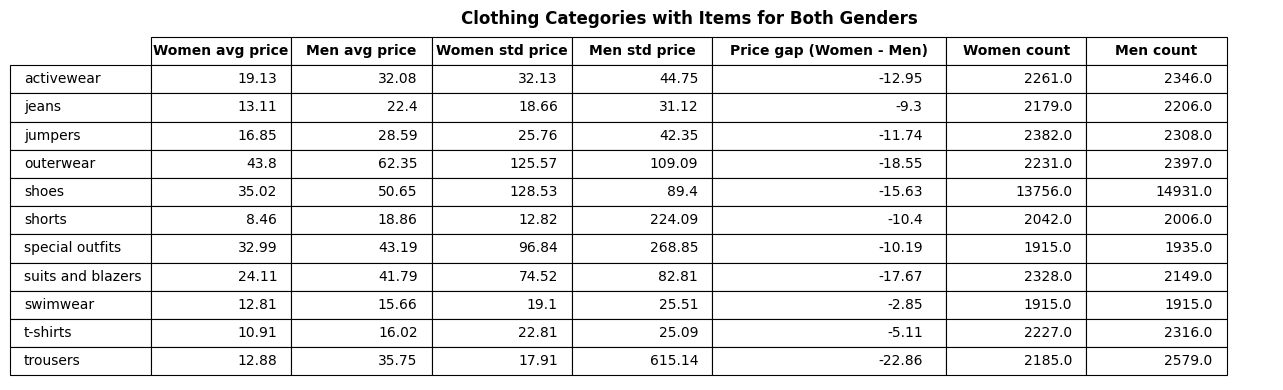

In [22]:
# This script analyzes the cleaned Vinted data to compare average prices, standard deviation, and number of items collected for both genders.

df = pd.read_json(output_path)

df["super_category"] = df["category_title"].map(super_category_dict)
df = df.dropna(subset=["super_category"])

category_col = "super_category"
gender_col = "gender"
price_col = "price"

# ---- Average price by clothing type and gender ----
avg_price = (
    df.groupby([category_col, gender_col])[price_col]
    .mean()
    .unstack()
    .reindex(columns=["femme", "homme"])
)

# ---- Standard deviation by clothing type and gender ----
std_price = (
    df.groupby([category_col, gender_col])[price_col]
    .std()
    .unstack()
    .reindex(columns=["femme", "homme"])
)

# ---- Number of items by clothing type and gender ----
counts = (
    df.groupby([category_col, gender_col])[price_col]
    .count()
    .unstack()
    .reindex(columns=["femme", "homme"])
)

# ---- Merge all metrics ----
summary = avg_price.join(
    counts, lsuffix="_avg", rsuffix="_count"
).join(
    std_price, rsuffix="_std"
)

# ---- Rename columns clearly ----
summary.columns = [
    "Women avg price", "Men avg price",
    "Women count", "Men count",
    "Women std price", "Men std price"
]

# ---- Price gap ----
summary["Price gap (Women - Men)"] = summary["Women avg price"] - summary["Men avg price"]

# ---- Filter only categories with both men and women items ----
summary = summary[(summary["Women count"] > 0) & (summary["Men count"] > 0)]

# ---- Round for presentation ----
summary = summary.round(2)

# ---- Reorder columns ----
summary = summary[
    [
        "Women avg price",
        "Men avg price",
        "Women std price",
        "Men std price",
        "Price gap (Women - Men)",
        "Women count",
        "Men count"
    ]
]

# ---- Render academic black & white table ----
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13, 4))  # slightly wider for std columns
ax.axis("off")

col_widths = [0.12, 0.12, 0.12, 0.12, 0.20, 0.12, 0.12]

table = ax.table(
    cellText=summary.values,
    colLabels=summary.columns,
    rowLabels=summary.index,
    colWidths=col_widths,
    loc="center"
)

# ---- Styling (academic) ----
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor("black")
    cell.set_linewidth(0.8)
    if row == 0:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("white")

plt.title(
    "Clothing Categories with Items for Both Genders",
    fontsize=12,
    weight="bold"
)

plt.tight_layout()
plt.show()


In [23]:
#This script prepares the cleaned Vinted data for visualization of price distributions by gender

with open(output_path, "r", encoding="utf-8") as f:
    items = json.load(f)

df = pd.DataFrame(items)

#Drop rows with missing price or gender
df = df.dropna(subset=["price", "gender"])

df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["price"])

#Map gender to markers for plotting
marker_map = {"femme": "o", "homme": "s"}  # circle for women, square for men
df["marker"] = df["gender"].map(marker_map)

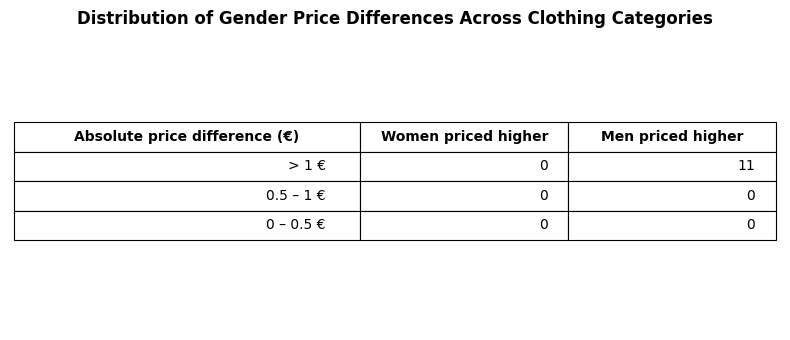

In [24]:
#This script analyzes the cleaned Vinted data to summarize the distribution of price differences between men and women across clothing categories.
df = pd.read_json(output_path)

df["super_category"] = df["category_title"].map(super_category_dict)
df = df.dropna(subset=["super_category"])

category_col = "super_category"
gender_col = "gender"
price_col = "price"


avg_price = (
    df.groupby([category_col, gender_col])[price_col]
    .mean()
    .unstack()
)

#Price gap 
avg_price["gap"] = avg_price["femme"] - avg_price["homme"]

# Drop categories missing one gender
avg_price = avg_price.dropna(subset=["gap"])

bins = [
    (1.0, float("inf"), "> 1 €"),
    (0.5, 1.0, "0.5 – 1 €"),
    (0.0, 0.5, "0 – 0.5 €")
]

rows = []

for low, high, label in bins:
    women_higher = ((avg_price["gap"] > low) & (avg_price["gap"] <= high)).sum()
    men_higher = ((avg_price["gap"] < -low) & (avg_price["gap"] >= -high)).sum()
    
    rows.append([label, women_higher, men_higher])

summary_table = pd.DataFrame(
    rows,
    columns=[
        "Absolute price difference (€)",
        "Women priced higher",
        "Men priced higher"
    ]
)

#Render academic black & white table
fig, ax = plt.subplots(figsize=(8, 3.5))
ax.axis("off")

table = ax.table(
    cellText=summary_table.values,
    colLabels=summary_table.columns,
    loc="center",
    colWidths=[0.45, 0.27, 0.27]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.6)

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor("black")
    cell.set_linewidth(0.8)
    if row == 0:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("white")

plt.title(
    "Distribution of Gender Price Differences Across Clothing Categories",
    fontsize=12,
    weight="bold"
)

plt.tight_layout()
plt.show()

In [25]:
MIN_FEMALE = 30
MIN_MALE = 30
output_csv_path = r"C:\\Users\\grogr\\Documents\\pink_gaps.csv" #indicate the right path to save the csv file


In [26]:
# Count observations by brand × category × gender
cell_counts = (
    df
    .groupby(["brand", "super_category", "gender"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Keep only balanced cells
interesting_cells = cell_counts[
    (cell_counts.get("femme", 0) >= MIN_FEMALE) &
    (cell_counts.get("homme", 0) >= MIN_MALE)
].copy()

print(f"Number of interesting intersections: {len(interesting_cells)}")


Number of interesting intersections: 74


In [27]:
mean_price_table = (
    df
    .pivot_table(
        index=["brand", "super_category"], 
        columns="gender",                   
        values="price",                     
        aggfunc="mean"                      
    )
    .round(2)                            
)
mean_price_table_filtered = mean_price_table.reset_index().merge(
    interesting_cells[["brand", "super_category"]],
    on=["brand", "super_category"],
    how="inner"
)
mean_price_table_filtered.to_csv(output_csv_path, index=False)
print(mean_price_table_filtered)



gender   brand super_category  femme  homme
0                  activewear  11.94  22.65
1                       jeans   6.76  11.40
2                     jumpers  10.06  22.40
3                   outerwear  37.63  42.37
4                       shoes  28.14  17.12
..         ...            ...    ...    ...
69        Zara       trousers   9.31  10.71
70      adidas     activewear  17.47  32.35
71      adidas        jumpers  27.71  21.29
72      adidas          shoes  42.20  42.47
73      adidas       trousers  15.78  18.19

[74 rows x 4 columns]


In [ ]:
csv_path = r"C:\\Users\\grogr\\Documents\\Telecom\\2A\\MODS\\Data analysis\\Résultats_econometrics\\pink_gaps.csv"  # change to your path (path that saves the mean_price_table_filtered file)
#We suppress the first lines of the previous data 
df = pd.read_csv(csv_path)


# Assign columns names for convenience
df.columns = ["brand", "super_category", "female_price", "male_price"]

# Compute price difference in euros
df["price_diff_eur"] = df.iloc[:, 2] - df.iloc[:, 3]

# Compute price difference in percent (relative to male price)
df["price_diff_pct"] = df["price_diff_eur"] / df.iloc[:, 3] * 100

# Compute average differences
avg_diff_eur = df["price_diff_eur"].mean()
avg_diff_pct = df["price_diff_pct"].mean()

print(f"Average pink gap in €: {avg_diff_eur:.2f}")
print(f"Average pink gap in %: {avg_diff_pct:.2f}%")

# Create a clean table
display_df = df[["brand", "super_category", "female_price", "male_price", "price_diff_eur", "price_diff_pct"]].copy()

# Format numbers
display_df["female_price"] = display_df["female_price"].map("€{:.2f}".format)
display_df["male_price"] = display_df["male_price"].map("€{:.2f}".format)
display_df["price_diff_eur"] = display_df["price_diff_eur"].map("€{:.2f}".format)
display_df["price_diff_pct"] = display_df["price_diff_pct"].map("{:.2f}%".format)

# Select 4 columns to save
output_df = df[["brand", "super_category", "price_diff_eur", "price_diff_pct"]].copy()

# Format numbers for Excel
output_df["price_diff_eur"] = output_df["price_diff_eur"].round(2)
output_df["price_diff_pct"] = output_df["price_diff_pct"].round(2)


# Add a row for averages
avg_row = pd.DataFrame({
    "brand": ["AVERAGE"],
    "super_category": [""],
    "price_diff_eur": [round(avg_diff_eur, 2)],
    "price_diff_pct": [round(avg_diff_pct, 2)]
})

# Append the average row
output_df = pd.concat([output_df, avg_row], ignore_index=True)

# Save to Excel
excel_path = "price_diff_report.xlsx"
output_df.to_excel(excel_path, index=False)

print(f"Excel file saved as {excel_path}")

# Print table
print(display_df.to_string(index=False))

# Print averages
print(f"\nAverage pink gap in €: €{avg_diff_eur:.2f}")
print(f"Average pink gap in %: {avg_diff_pct:.2f}%")

Average pink gap in €: -5.09
Average pink gap in %: -11.84%
Excel file saved as price_diff_report.xlsx
           brand    super_category female_price male_price price_diff_eur price_diff_pct
            ASOS             shoes       €12.80     €17.67         €-4.87        -27.56%
           Arena          swimwear       €19.57     €21.15         €-1.58         -7.47%
           Asics             shoes       €54.64     €62.67         €-8.03        -12.81%
         Bershka             jeans        €8.83     €10.94         €-2.11        -19.29%
         Bershka            shorts        €8.15      €7.98          €0.17          2.13%
         Bershka          trousers        €7.78     €12.11         €-4.33        -35.76%
     Birkenstock             shoes       €58.83     €62.79         €-3.96         -6.31%
          Clarks             shoes       €25.30     €52.09        €-26.79        -51.43%
        Converse             shoes       €21.89     €36.13        €-14.24        -39.41%
       

In [ ]:

# Create the raw data (brand, super_category, female_price, male_price)
data = [
    ["ASOS", "shoes", 12.80, 17.67],
    ["Arena", "swimwear", 19.57, 21.15],
    ["Asics", "shoes", 54.64, 62.67],
    ["Bershka", "jeans", 8.83, 10.94],
    ["Bershka", "shorts", 8.15, 7.98],
    ["Bershka", "trousers", 7.78, 12.11],
    ["Birkenstock", "shoes", 58.83, 62.79],
    ["Clarks", "shoes", 25.30, 52.09],
    ["Converse", "shoes", 21.89, 36.13],
    ["Crocs", "shoes", 30.51, 33.97],
    ["Dr. Martens", "shoes", 75.26, 86.16],
    ["Geox", "shoes", 24.40, 27.94],
    ["Gucci", "shoes", 215.36, 222.92],
    ["Gymshark", "activewear", 13.33, 24.87],
    ["H&M", "jeans", 8.12, 8.93],
    ["H&M", "shoes", 10.93, 11.08],
    ["H&M", "shorts", 4.88, 6.97],
    ["H&M", "suits and blazers", 10.84, 12.98],
    ["H&M", "swimwear", 6.60, 4.80],
    ["H&M", "t-shirts", 6.01, 5.45],
    ["H&M", "trousers", 6.22, 7.33],
    ["Havaianas", "shoes", 13.04, 12.78],
    ["Hoka", "shoes", 71.29, 80.42],
    ["Jordan", "shoes", 62.60, 80.30],
    ["Levi's", "jeans", 22.93, 24.62],
    ["Levi's", "shorts", 13.96, 15.79],
    ["Local", "shoes", 13.56, 16.92],
    ["Marks & Spencer", "shoes", 13.43, 24.98],
    ["New Balance", "shoes", 50.45, 65.88],
    ["Next", "shoes", 12.65, 11.68],
    ["Nike", "activewear", 13.56, 35.33],
    ["Nike", "shoes", 40.98, 62.89],
    ["Nike Air", "shoes", 42.54, 57.54],
    ["Primark", "shoes", 5.76, 6.88],
    ["Pull & Bear", "jeans", 8.46, 10.35],
    ["Puma", "shoes", 33.07, 32.96],
    ["Ralph Lauren", "jumpers", 54.30, 48.10],
    ["Salomon", "shoes", 70.91, 94.56],
    ["Skechers", "shoes", 22.87, 32.45],
    ["Sonstiges", "shoes", 12.48, 20.43],
    ["Sonstiges", "special outfits", 19.85, 22.32],
    ["The North Face", "outerwear", 55.18, 66.87],
    ["Timberland", "shoes", 45.99, 66.66],
    ["Tommy Hilfiger", "shoes", 28.38, 31.16],
    ["Toms", "shoes", 16.07, 20.48],
    ["UGG", "shoes", 72.37, 82.25],
    ["Vans", "shoes", 24.35, 30.15],
    ["Vera Pelle", "shoes", 26.23, 34.87],
    ["Vintage Dressing", "jumpers", 27.78, 22.02],
    ["Vintage Dressing", "outerwear", 35.98, 42.91],
    ["Vintage Dressing", "suits and blazers", 24.94, 21.34],
    ["Zara", "jeans", 9.31, 14.08],
    ["Zara", "jumpers", 13.48, 11.47],
    ["Zara", "outerwear", 43.25, 23.22],
    ["Zara", "shoes", 20.30, 22.14],
    ["Zara", "shorts", 10.09, 9.12],
    ["Zara", "suits and blazers", 22.33, 21.73],
    ["Zara", "t-shirts", 10.53, 9.01],
    ["Zara", "trousers", 9.31, 10.71],
    ["adidas", "activewear", 17.47, 32.35],
    ["adidas", "jumpers", 27.71, 21.29],
    ["adidas", "shoes", 42.20, 42.47],
    ["adidas", "trousers", 15.78, 18.19],
]

# Create DataFrame
df = pd.DataFrame(data, columns=["brand", "super_category", "female_price", "male_price"])

# Compute price differences
df["price_diff_eur"] = df["female_price"] - df["male_price"]
df["price_diff_pct"] = df["price_diff_eur"] / df["male_price"] * 100

# Round numeric columns
df["female_price"] = df["female_price"].round(2)
df["male_price"] = df["male_price"].round(2)
df["price_diff_eur"] = df["price_diff_eur"].round(2)
df["price_diff_pct"] = df["price_diff_pct"].round(2)

# Compute averages
avg_row = pd.DataFrame({
    "brand": ["AVERAGE"],
    "super_category": [""],
    "female_price": [df["female_price"].mean().round(2)],
    "male_price": [df["male_price"].mean().round(2)],
    "price_diff_eur": [df["price_diff_eur"].mean().round(2)],
    "price_diff_pct": [df["price_diff_pct"].mean().round(2)],
})

# Append average row
df = pd.concat([df, avg_row], ignore_index=True)

# Save to Excel
excel_path = "pink_gap_report.xlsx"
df.to_excel(excel_path, index=False)

print(f"Excel file with 6 columns saved as {excel_path}")




Excel file with 6 columns saved as pink_gap_report.xlsx
